# Chapter 6 게이트가 추가된 RNN

기본 RNN은 시간적으로 멀리 떨어진 장기 의존 관계를 잘 학습하기 어려워서 성능이 좋지 못하다.

LSTM과 GRU는 게이트(gate)라는 구조가 더해져 장기 의존 관계 또한 학습할 수 있다.

## 6.1 RNN의 문제점

문제: 장기 의존 관계를 학습하기 어렵다.  
원인: 기울기 소실 또는 기울기 폭발 발생

### 6.1.1 RNN 복습

바로 이전 시각의 은닉 상태를 이용해서 과거 정보를 기억 계승할 수 있다.

### 6.1.2 기울기 소실 또는 기울기 폭발

RNN 계층에서 과거 방향으로 의미 있는 기울기를 전달해서 장기 의존 관계를 학습해야 한다. 하지만 중간에 기울기가 사라지면 의미 있는 정보는 사라지게 되고 장기 의존 관계를 학습할 수 없게 된다. 단순한 RNN 계층에서는 기울기 소실 또는 기울기 폭발로 대부분 이어진다.

### 6.1.3 기울기 소실과 기울기 폭발의 원인

+의 역전파는 상류의 기울기를 단순히 하류로 보낼 뿐이므로 tanh와 MatMul에서 기울기 변화를 봐야 한다.

#### tanh

<img src="./images/fig 6-6.png" width=600>

tanh 노드를 지날 때마다 기울기 값은 계속 작아진다. RNN 계층의 활성화 함수로 tanh를 주로 사용하는데 ReLU로 바꾸면 기울기 소실을 줄일 수 있다.

#### MatMul(tanh는 무시하면)

<img src="./images/fig 6-7.png" width=600>

매번 똑같은 $W_h$가 행렬 곱셈에서 사용된다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3)   # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

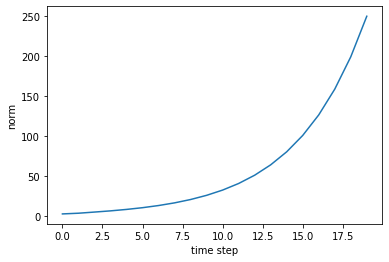

In [4]:
plt.plot(range(len(norm_list)), norm_list)
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

**기울기 폭발(exploding gradients)** 발생, 기울기 폭발이 발생하면 오버플로를 일으켜 NaN 값이 발생해서 제대로된 학습이 불가능하다.

In [5]:
N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3)   # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H) * 0.5  # 분포 변경

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

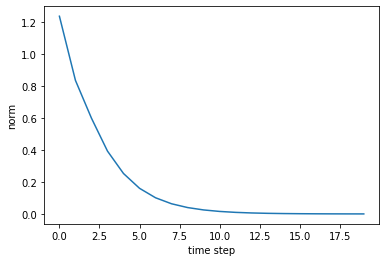

In [6]:
plt.plot(range(len(norm_list)), norm_list)
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

**기울기 손실** 발생, 기울기가 일정 수준 이하로 감소하면 더이상 갱신이 일어나지 않아서 장기 의존 관계를 학습할 수 없다. 

행렬의 경우에는 특잇값의 최댓값이 1보다 크면 지수적으로 증가하고, 1보다 작으면 지수적으로 감소할 가능성이 크다.

### 6.1.4 기울기 폭발 대책

#### 기울기 클리핑(gradients clipping)

기울기 폭발의 대책

<img src="./images/e 6-0.png" width=200>

In [8]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad += rate

## 6.2 기울기 소실과 LSTM

### 6.2.1 LSTM의 인터페이스

<img src="./images/fig 6-11.png" width=800>

**c: 기억 셀(memory cell)**이 추가되었다. 기억 셀은 LSTM 계층 내에서만 데이터를 주고 받는다. 출력으로 받는 쪽은 은닉 상태 h 뿐이므로 c를 생각할 필요가 없다.

### 6.2.2 LSTM 계층 조립하기

기억 셀 $c_t$에는 과거로부터 시각 $t$까지에 필요한 모든 정보가 저장돼 있다고 가정한다. 이 기억 셀을 바탕으로 외부 계층과 다음 시각의 LSTM에 은닉 상태 $h_t$를 출력한다.

기억 셀 $c_t$는 3개의 입력($c_{t-1}, h{t-1}, x_t$)의 계산을 통해 얻어진다. $h_t = tanh(c_t)$이다. $h_t$를 계산할 때 갱신된 기억 셀을 이용한다는 점을 주의해야 한다.

게이트는 흐름을 제어하는 역할을 한다. 게이트의 열림 상태는 0.0~1.0 사이의 실수로 나타내고, 이 값도 데이터로부터 자동으로 학습한다. 게이트의 열림 상태를 학습할 땐 시그모이드 함수를 이용한다.

### 6.2.3 output 게이트

output 게이트는 $tanh(c_t)$의 각 원소에 대해 다음 시각의 은닉 상태에 얼마나 중요한가를 조정한다.

output 게이트의 열림 상태는 입력 $x_t$와 이전 상태 $h_{t-1}$로부터 구한다.

$$o = \sigma(x_tW_x^{(0)}+h_{t-1}W_h^{(0)}+b^{(0)})$$

출력 게이트의 o와 $tanh(c_t)$의 원소별 곱을 $h_t$로 출력한다.

$$h_t = o \odot tanh(c_t)$$

tanh는 인코딩된 정도를 표시하고, 시그모이드는 데이터를 얼마만큼 통과시킬지를 정하는 비율로 해석할 수 있다. 따라서 주로 게이트에는 시그모이드를, 실질적인 정보를 지니는 데이터에는 tanh 함수를 활성화 함수로 사용한다.

### 6.2.4 forget 게이트

**forget 게이트(망각 게이트)**는 $c_{t-1}$의 기억 중에서 불필요한 기억을 잊게 해주는 게이트이다.

<img src="./images/fig 6-16.png" width=500>

$$f = \sigma(x_tW_x^{(f)} + h_{t-1}W_h^{(f)} + b^{(f)})$$

망각 게이트의 출력 f와 이전 기억 셀인 $c_{t-1}$과의 원소별 곱을 통해 $c_t$를 구한다.

### 6.2.5 새로운 기억 셀

<img src="./images/fig 6-17.png" width=500>

$$g = tanh(x_tW_x{(g)} + h_{t-1}W_h^{(g)} + b^{(g)})$$

tanh 노드는 게이트가 아니며, 새로운 정보를 기억 셀에 추가하는 것이 목적이다. g가 이전 시각의 기억 셀에 더해져서 새로운 기억이 생겨난다.

### 6.2.6 input 게이트

<img src="./images/fig 6-18.png" width=500>

input 게이트는 g의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지를 판단한다. input 게이트에 의해 가중된 정보가 새로 추가되는 것과 같다.

$$i = \sigma(x_tW_x^{(i)} + h_{t-1}W_h^{(i)} + b^{(i)})$$

i와 g의 원소별 곱 결과를 기억 셀에 추가한다.

### 6.2.7 LSTM의 기울기 흐름

<img src="./images/fig 6-19.png">

기억 셀의 역전파는 +와 x 노드만을 갖는다. +는 상류에서 전해지는 기울기를 그대로 흘린다. x 노드는 원소별 곱이다. 매 시각 다른 게이트 값을 이용해서 원소별 곱을 계산하기 때문에 곱셈의 효과가 누적되지 않아 기울기 소실이 잘 일어나지 않는다.

x 노드의 계산은 forget 게이트가 제어하고 매 시각 다른 게이트 값을 출력한다. forget 게이트가 잊어야 한다고 판단한 셀의 원소에 대해서는 기울기가 작아진다. forget 게이트가 잊어서는 안 된다 판단한 원소에 대해서는 그 기울기가 약화되지 않은 채로 과거 방향으로 전해진다. 따라서 오래 기억해야 하는 정보일 경우 기울기 소실 없이 전파될 수 있다.

## 6.3 LSTM 구현

#### LSTM에서 수행하는 계산

$$f = \sigma(x_tW_x^{(f)}+h_{t-1}W_h^{(f)}+b^{(f)})$$
$$g = tanh(x_tW_x^{(g)}+h_{t-1}W_h^{(g)}+b^{(g)})$$
$$i = \sigma(x_tW_x^{(i)}+h_{t-1}W_h^{(i)}+b^{(i)})$$
$$o = \sigma(x_tW_x^{(o)}+h_{t-1}W_h^{(o)}+b^{(o)})$$

$$c_t = f \odot c_{t-1} + g \odot i$$

$$h_t = o \odot tanh(c_t)$$

위의 네 수식에는 **아핀 변환(affine transformation)**이 포함되어있다. 아핀 변환은 행렬 변환과 평행 이동을 결합한 상태로 $xW_x + hW_h + b$ 형태의 식을 말한다. 아핀 변환을 한꺼번에 모아 처리할 수 있다. 한번에 처리하면 계산 속도가 빨라지고 코드를 간결하게 할 수 있다.

<img src="./images/fig 6-20.png" width=700>

<img src="./images/fig 6-21.png" width=700>

아핀 변환을 한꺼번에 수행한 다음 slice 노드를 통해 아핀 변환의 결과를 균등하게 나눠서 다음 계산을 수행한다.

In [1]:
class LSTM:
    
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        # 4개분의 아핀 변환
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        
        return h_next, c_next

<img src="./images/fig 6-23.png" width=700>

slice 노드는 순전파에서 행렬을 4조각으로 나눠 분배했다. 역전파 때는 4개의 행렬을 다시 연결해주어야 하는데 np.hstack()으로 배열을 가로로 연결한다. 별개로, 세로로 연결하는 np.vstack()도 있다.

### 6.3.1 Time LSTM 구현

T개의 시계열 데이터를 한꺼번에 처리하는 계층이다. 기본 RNN에서 Truncated BPTT처럼 수행한다. 기본 RNN과의 차이는 기억 셀이 추가되었기 때문에 은닉 상태와 기억 셀을 인스턴스 변수로 유지해서 이전 시각의 은닉 상태와 기억 셀에서부터 시작할 수 있도록 한다.

In [3]:
class TimeLSTM:
    
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
            
        return hs
    
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            
        self.dh = dh
        return dxs
    
    
    def set_state(self, h, c=None):
        self.h, self.c = h, c
        
        
    def reset_state(self):
        self.h, self.c = None, None

## 6.4 LSTM을 사용한 언어 모델

이전과의 유일한 차이는 LSTM을 이용한다는 점이다.

In [4]:
from common.time_layers import *
import pickle

In [5]:
class Rnnlm:
    
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
            
        return xs
    
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(xs, ts)
        
        return loss
    
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
            
        return dout
    
    
    def reset_state(self):
        self.lstm_layer.reset_state()
        
        
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
            
    
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

predict() 메소드는 Softmax 계층 직전까지 처리한다.

PTB 데이터셋의 훈련 데이터 전부 이용해서 학습

In [6]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.39
| 에폭 1 |  반복 21 / 1327 | 시간 6[s] | 퍼플렉서티 2650.64
| 에폭 1 |  반복 41 / 1327 | 시간 12[s] | 퍼플렉서티 1225.51
| 에폭 1 |  반복 61 / 1327 | 시간 18[s] | 퍼플렉서티 981.06
| 에폭 1 |  반복 81 / 1327 | 시간 24[s] | 퍼플렉서티 789.71
| 에폭 1 |  반복 101 / 1327 | 시간 30[s] | 퍼플렉서티 636.15
| 에폭 1 |  반복 121 / 1327 | 시간 37[s] | 퍼플렉서티 627.82
| 에폭 1 |  반복 141 / 1327 | 시간 43[s] | 퍼플렉서티 615.01
| 에폭 1 |  반복 161 / 1327 | 시간 49[s] | 퍼플렉서티 551.18
| 에폭 1 |  반복 181 / 1327 | 시간 55[s] | 퍼플렉서티 578.53
| 에폭 1 |  반복 201 / 1327 | 시간 61[s] | 퍼플렉서티 513.17
| 에폭 1 |  반복 221 / 1327 | 시간 68[s] | 퍼플렉서티 497.55
| 에폭 1 |  반복 241 / 1327 | 시간 74[s] | 퍼플렉서티 445.34
| 에폭 1 |  반복 261 / 1327 | 시간 80[s] | 퍼플렉서티 460.05
| 에폭 1 |  반복 281 / 1327 | 시간 86[s] | 퍼플렉서티 455.48
| 에폭 1 |  반복 301 / 1327 | 시간 92[s] | 퍼플렉서티 395.25
| 에폭 1 |  반복 321 / 1327 | 시간 98[s] | 퍼플렉서티 340.93
| 에폭 1 |  반복 341 / 1327 | 시간 104[s] | 퍼플렉서티 398.79
| 에폭 1 |  반복 361 / 1327 | 시간 110[s] | 퍼플렉서티 403.62
| 에폭 1 |  반복 381 / 1327 | 시간 117[s] | 퍼플렉서티 339.89
| 

| 에폭 3 |  반복 541 / 1327 | 시간 993[s] | 퍼플렉서티 136.32
| 에폭 3 |  반복 561 / 1327 | 시간 999[s] | 퍼플렉서티 120.87
| 에폭 3 |  반복 581 / 1327 | 시간 1005[s] | 퍼플렉서티 106.72
| 에폭 3 |  반복 601 / 1327 | 시간 1011[s] | 퍼플렉서티 150.41
| 에폭 3 |  반복 621 / 1327 | 시간 1018[s] | 퍼플렉서티 145.63
| 에폭 3 |  반복 641 / 1327 | 시간 1024[s] | 퍼플렉서티 130.95
| 에폭 3 |  반복 661 / 1327 | 시간 1030[s] | 퍼플렉서티 121.36
| 에폭 3 |  반복 681 / 1327 | 시간 1036[s] | 퍼플렉서티 101.26
| 에폭 3 |  반복 701 / 1327 | 시간 1042[s] | 퍼플렉서티 118.22
| 에폭 3 |  반복 721 / 1327 | 시간 1048[s] | 퍼플렉서티 128.83
| 에폭 3 |  반복 741 / 1327 | 시간 1054[s] | 퍼플렉서티 108.44
| 에폭 3 |  반복 761 / 1327 | 시간 1060[s] | 퍼플렉서티 105.25
| 에폭 3 |  반복 781 / 1327 | 시간 1067[s] | 퍼플렉서티 105.48
| 에폭 3 |  반복 801 / 1327 | 시간 1073[s] | 퍼플렉서티 116.00
| 에폭 3 |  반복 821 / 1327 | 시간 1079[s] | 퍼플렉서티 116.96
| 에폭 3 |  반복 841 / 1327 | 시간 1085[s] | 퍼플렉서티 117.05
| 에폭 3 |  반복 861 / 1327 | 시간 1091[s] | 퍼플렉서티 122.15
| 에폭 3 |  반복 881 / 1327 | 시간 1097[s] | 퍼플렉서티 106.75
| 에폭 3 |  반복 901 / 1327 | 시간 1103[s] | 퍼플렉서티 132.01
| 에폭 3 |  반복 9

C:\Users\KJK\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KJK\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KJK\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KJK\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KJK\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KJK\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54540 missing from current font.
  f

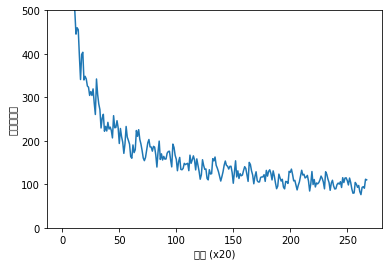

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  136.28636288384914


In [8]:
# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

테스트 데이터로 검증했을 때 136 정도의 퍼플렉서티를 달성했는데 좋은 성능은 아니다. 최근 연구에서 PTB 데이터셋의 퍼플렉서티는 60을 밑돈다.

## 6.5 RNNLM 추가 개선

### 6.5.1 LSTM 계층 다층화

LSTM 계층을 여러 개로 쌓으면 더 복잡한 패턴을 학습할 수 있을 것이다.

PTB 데이터셋에서는 2~4개의 층이 적합하다고 한다. 층의 갯수는 하이퍼파라미터이므로 실험을 통해 적절한 수를 찾아야 한다.

구글 번역에 사용하는 GNMT 모델은 LSTM을 8층으로 쌓았다. 문제가 복잡하고 학습 데이터를 대량으로 준비할 수 있으면 LSTM 계층을 깊게 쌓을 경우 정확도 향상을 기대할 수 있다.

### 6.5.2 드롭아웃에 의한 과적합 억제

층을 깊게 쌓으면 풍부한 표현력을 얻을 수 있지만 RNN은 일반적인 피드포워드 신경망보다 과적합이 쉽게 일어난다.

과적합에 대한 대책으로 훈련 데이터 양 늘리기, 모델의 복잡도를 줄이는 방법이 있다. 모델의 복잡도에 페널티를 주는 정규화와 드롭아웃이 효과적이다.

#### RNN에서 드롭아웃 계층을 삽입하는 위치

첫번째 방법은 시계열 방향으로 넣는 것이다. 이는 시간이 흐름에 따라 정보가 사라질 수 있다는 단점이 있기 때문에 권장하는 방법은 아니다.

두번째 방법은 깊이 방향(상하 방향)으로 삽입하는 것이다. 시간 방향으로 진행해도 정보를 잃지 않기 때문에 이 방식이 권장된다.

일반적인 드롭아웃은 시간 방향으로 삽입하지 않는데 **변형 드롭아웃(variational dropout)**은 시간 방향으로 드롭아웃을 적용했고 일반적인 드롭아웃보다 좋은 성능을 보였다. 변형 드롭아웃은 깊이 방향과 시간 방향 모두에서 드롭아웃을 수행한다. 같은 층에 속한 드롭아웃은 같은 마스크를 공유한다. 같은 계층에서 잃게 되는 정보가 고정되므로 정보가 지수적으로 손실되는 것을 막을 수 있다.

<img src="./images/fig 6-34.png" width=700>

### 6.5.3 가중치 공유

<img src="./images/fig 6-35.png" width=500>

가중치 공유(weight typing)은 가중치를 연결해서 가중치를 공유하는 효과를 준다. 

Embedding 계층과 Affine 계층의 가중치를 공유하는 기법을 가중치 공유라고 한다. 학습하는 매개변수 수가 크게 줄어듦과 동시에 정확도도 향상된다.

